In [1]:
import joblib
import pandas as pd
import colorama as col
from matplotlib import pyplot as plt
import ffn
import numpy as np
import datetime as dt
import fxcmpy
from tqdm import tqdm
import sys
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, precision_recall_curve, confusion_matrix, classification_report, f1_score, roc_auc_score
sys.path.append('../') 
import pyttsx3
engine = pyttsx3.init()
from slack_sdk import WebClient
_slack_token = joblib.load('TOKENS/_slack_token.dag')
client = WebClient(token=_slack_token)
import time
import warnings
import talib
#from pycaret.regression import *
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [2]:
TIK = ['AUD','NZD','GBP','JPY','CHF','CAD','SEK','NOK','ILS','MXN','USD','EUR']
RATE = [0.776,0.721,1.3912,1/105.91,1/0.892,1/1.2681,1/8.2884,1/8.4261,1/3.2385,1/20.1564,1,1/1.21]
df_ratefx = pd.DataFrame(index=TIK)
df_ratefx['rate'] = RATE

x = 'EUR/USD'
_period = 'm5'
_period2 = 'H1'
_ticker = x.replace('/','')
_start = '2010-01-01' # start the train there '2010-01-01'
_mid = '2016-06-30' # stop the train and begin the test there '2016-08-31'
_stop = '2017-12-31' # stop the test there. After that, it is kept for oos '2017-12-31'
_last = '2021-04-29' # '2020-12-31'
_nb_bougie_exit = 20
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 0
_trigger_rsi = 0
_verbose = 0
_cash_ini = 200000
_target = 0.001
_sl = 0.001
_exposure = 2
_rate = df_ratefx.loc[x[4:],'rate']
_size = _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0

In [3]:
database = joblib.load('BASES/'+_ticker+'_'+_period)
df_H1 = joblib.load('BASES/'+_ticker+'_'+_period2)

In [4]:
def perq(df,_window=20) :
    df['HH'] = df['High'].rolling(_window).max()
    df['LL'] = df['Low'].rolling(_window).min()
    df['PerQ'] = (df.HH - df.Close)/(df.HH - df.LL)
    df = df.drop(['HH','LL'],axis=1)
    return(df)

def coinflip(df):
    df['Signal'] = np.random.randint(3, size=len(df))-1
    return(df)

def timerange1D(df):
    df['Date'] = df.index
    df['Date'] = df['Date'].dt.strftime(date_format='%Y-%m-%d')
    return(df.sort_index(axis=0))

def split_learn(df):
    """[Split the dtaframe in train/test/oos and reduce train and test to dataframe with signal!=0 only]

    Args:
        df ([pandas]): [the datframe to split already featured]
        _start ([date]): [beginning of the df]
        _mid ([date]): [stop of the train and beginning of the test]
        _stop ([date]): [stop of the test and beginning of the oos]
        _last ([date]): [end of the oos]
    """    
    df = df.dropna()
    df['Date'] = pd.to_datetime(df.Date)
    df_train = df[(df.Date>=_start)&(df.Date<=_mid)]
    df_test = df[(df.Date>_mid)&(df.Date<=_stop)]
    df_oos = df[(df.Date>_stop)&(df.Date <= _last)]
    df_train = df_train[df_train.Signal!=0]
    df_test = df_test[df_test.Signal!=0]
    return(df_train, df_test,df_oos)

def strategy(df,_window=20):
    df = perq(df,_window)
    _condition1 = (df.PerQ == 1)
    _condition2 = (df.PerQ == 0)
    df['Signal'] = np.where(_condition1,1,np.where(_condition2,-1,0))
    df['Signal'] = df['Signal'].shift(_window)
    return(df)

def strategy_rsi(df,_window=2):
    ##### CONDITIONS SHORT
    _condition_1_bar = (df.MYRSI_2 > 90) & (df.Close < df.SMA_200) & (df.MYRSI_2.shift() > df.MYRSI_2.shift(2)) \
        & (df.MYRSI_2.shift(2) > 80 )

    ##### CONDITIONS LONG
    _condition_1 = (df.MYRSI_2 < 10) & (df.Close > df.SMA_200) & (df.MYRSI_2.shift() < df.MYRSI_2.shift(2)) \
        & (df.MYRSI_2.shift(2) < 20 )

    ##### 1 condition
    df['Signal'] = np.where(_condition_1,1,np.where(_condition_1_bar,-1,0))
    return(df.sort_index(axis=0))

def strategy_calibration(df,_window=40):

    df['RSI_'+str(2)] = talib.RSI(df.Close,2)
    df['EMA200'] = talib.EMA(df.Close,200)

    df['Window_High_Ask'] = df.HighAsk.iloc[::-1].rolling(_window).max().iloc[::-1] # Limite SL Short
    df['Window_High_Bid'] = df.HighBid.iloc[::-1].rolling(_window).max().iloc[::-1] # Limite Target Long
    df['Window_Low_Ask'] = df.LowAsk.iloc[::-1].rolling(_window).min().iloc[::-1] # Limite Target Short
    df['Window_Low_Bid'] = df.LowBid.iloc[::-1].rolling(_window).min().iloc[::-1] # Limite SL Long
    df['Window_sl_Short'] = df.CloseBid + (df.CloseBid * _sl) # Short pour SL
    df['Window_sl_Long'] = df.CloseAsk - (df.CloseAsk * _sl) # Long pour SL
    df['Window_tp_Short'] = df.CloseBid - (df.CloseBid * _target) # Short pour TP
    df['Window_tp_Long'] = df.CloseAsk + (df.CloseAsk * _target) # Long pour TP

    ##### CONDITIONS LONG
    _condition_1 = (df['Window_tp_Long'] <= df['Window_High_Bid']) & (df['Window_sl_Long'] <= df['Window_Low_Bid'])

    ##### CONDITIONS SHORT
    _condition_1_bar = (df['Window_tp_Short'] >= df['Window_Low_Ask']) & (df['Window_sl_Short'] >= df['Window_High_Ask'])

    ##### 1 condition
    df['Signal'] = np.where(_condition_1,1,np.where(_condition_1_bar,-1,0))
    return(df.sort_index(axis=0))

def DagMaxBase(df):
    """[Generate future_max for scaling]

    Args:
        df ([pandas]): [Generate a new]
    """ 
    # max([abs(df_train[label]).max(),abs(df_train[label]).max()])
       
    features_max = pd.DataFrame()
    try:
        for label in df.drop(['Date','Symbol','Signal'],axis=1).columns:
            features_max.loc[0,label] = abs(df[label]).max()
    except:
        for label in df.drop(['Date','Symbol'],axis=1).columns:
            features_max.loc[0,label] = abs(df[label]).max()   
    
    joblib.dump(features_max,'VARS/'+_ticker+'/'+_ticker+'_MAX.dag')
    return(features_max)
def bt(price,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_save=0,_bt_report=0,_trigger_rsi=_trigger_rsi):
    engine = pyttsx3.init()

    print(col.Fore.YELLOW)
    print('\n_________________________________________________\n')
    print('__________________________________')
    print('     ___ Period 1 : => ', _period,' ___')
    print('     ___ Period 2 : => ', _period2,' ___')
    print('__________________________________')
    print('Ca$h Ini :',_cash_ini)
    print('Date début:',_year_bottom)
    print('Date fin :',_year_top)
    print('Etat verbose :',_verbose)
    print('Nombre Bougies Exit :',_nb_bougie_exit)
    print('Target :',_target)
    print('Stop Loss :',_sl)
    print('Trigger Reengage :',_trigger_reengage)
    print('Trigger Target :',_trigger_target)
    print('Trigger Inverse :',_trigger_invers)
    print('Trigger StopLoss :',_trigger_sl)
    print('Trigger RSI :',_trigger_rsi)
    print('Exposure :',_exposure)
    print('_bt_report : ',_bt_report)
    print('Verbose : ',_verbose)
    print('Trigger Spread :',_trigger_spread)
    print('Save : ',_save)
    print('\n_________________________________________________\n')
    print(col.Style.RESET_ALL)

    engine.say("Backtesting in progress")
    engine.runAndWait()


    _t1 = dt.datetime.now()
    print('Début des opérations horodatée à',dt.datetime.now())
    print('\n _trigger_rsi :',_trigger_rsi,'\n')

    _total = 0
    _cash = _cash_ini
    _pnl = 0
    _tracker = 0

    DATE = []
    CONTRACT = []
    OPEN_POZ = []
    CLOSE_POZ = []
    RATE_OPEN_POZ = []
    RATE_CLOSE_POZ = []
    PNL_LAT = []
    PNL_REAL = []
    TOTAL_OPEN = []
    TOTAL_CLOSE = []
    PRICE_BUY = []
    PRICE_SELL = []
    DER_POZ = []
    TOTAL_PNL_LAT = []
    TOTAL_PNL_REAL = []
    EXPO_MAX = []
    TRACKER = []
    TRADE_DURATION = []
    PRICE_BUY = []
    PRICE_SELL = []
    EQUITY = []
    CASH = []
    
    df_resultats = pd.DataFrame(index=['Equity','Nbre Winners','Nbre winners long','Nbre winners short','Nbre Loosers','Nbre loosers long','Nbre loosers short','Max lenght of trade','Min lenght of trade',\
        'Average lenght of trade','Cumul pnl'])
    
    print('\nChargement de la nouvelle base\n\n')

    engine.say("קדימה")
    engine.runAndWait()

    print(col.Fore.MAGENTA,'Le rate du ticker',x,'est à ',_rate,col.Style.RESET_ALL)

    price = price[(price.index >= _year_bottom) & (price.index <= _year_top)]
    print('Bases chargées')

    print('TETEL process effectué')

    print(col.Fore.CYAN,'ENTERING THE BACKTEST',col.Style.RESET_ALL)

    time.sleep(0.2)
        
    price = price.dropna()

    _position = 0
    _equity = 0
    _nbtransactions = 0
    backtest_graph = pd.DataFrame()

    _winner = 0
    _looser = 0
    _longwinner = 0
    _longlooser = 0
    _shortwinner = 0
    _shortlooser = 0
    _index_entry = 0
    
    _average_duration = 0
    _total = 0

    

    _open_buy = 0
    _open_sell = 0

    for i in tqdm(range(0,len(price))):

        _size = _cash_ini / df_ratefx.loc[x[:3],'rate']

        ##### POSITIONS EN L'AIR 
        if i >= (len(price)-1) and (_position == 1 or _position == -1) :

            if _position == -1:
                _position = 99
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_sell
                    _longwinner+=_open_sell
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                
                TRADE_DURATION.append(i - _index_entry)
                
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_sell,'position closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            if _position == 1:

                _position = 99
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_buy,'positions closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
        
        # SI PAS DE POSITION
        if _position == 0:
            # BUY SIGNAL
            if  price.Signal[i] == 1: 
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 

            # SELL SIGNAL
            elif price.Signal[i] == -1: 
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            else :
                _pnl = 0
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                PNL_LAT.append(0)
                PNL_REAL.append(0)
                continue
        
        # SI POSITION LONG
        elif _position == 1:

            ### RE_ENGAGE BUY ON VALID SIGNAL
            if price.Signal[i] == 1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1\
                 and _open_buy < _exposure :
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position (REENG) 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
            
            ### CLOSE LONG ON RSI DROUP OUT
            if _trigger_rsi == 1 and price.MYRSI_2[i] > 85:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (RSI) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (RSI) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            ### CLOSE LONG ON INVERSE SIGNAL
            if price.Signal[i] == -1 and _trigger_invers == 1:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            ### CLOSE LONG ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            # CLOSE LONG ON TARGET
            if (float(price.HighBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) >= _target and _trigger_target == 1:
                _position = 0
                _pnl = (price.HighBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            # CLOSE LONG ON STOP LOSS
            if (float(price. LowBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) <= - _sl and _trigger_sl == 1:
                _position = 0
                _pnl = (price.LowBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            else:

                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 
 
        # SI POSITION SHORT
        elif _position == -1:

            ### RE-ENGAGE SELL ON VALID SIGNAL
            if price.Signal[i] == -1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1 \
                and _open_sell < _exposure :
                
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position (REENG) 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            ### CLOSE SHORT ON RSI DROUP OUT
            if _trigger_rsi == 1 and price.MYRSI_2[i] < 15:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (RSI) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (RSI) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON INVERSE SIGNAL
            if price.Signal[i] == 1 and _trigger_invers == 1:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TARGET
            if (float(price.LowAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) <= -_target and _trigger_target == 1:
                _position = 0
                _pnl = - (price.LowAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON STOP LOSS
            if (float(price.HighAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) > _sl and _trigger_sl == 1:
                _position = 0
                _pnl = - (price.HighAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            else:

                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _equity = _cash + _pnl

                EQUITY.append(_equity)
                CASH.append(_cash)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
        

    try:
        _average_duration = round(sum(TRADE_DURATION)/len(TRADE_DURATION),2)
        _max_duration = max(TRADE_DURATION)
        _min_duration = min([item for item in TRADE_DURATION if item !=0])

    except:
        print("(No Duration)") 
        _average_duration = 'NA'
        _max_duration = 0.00002
        _min_duration = 0.00001 
    print(col.Fore.BLUE,'For ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    if _total > 0:              
        print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.GREEN,round(_total,2),'. En ',\
            _nbtransactions,col.Style.RESET_ALL,' transactions.' )
    else:
        print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.RED,round(_total,2),'. En ',\
            _nbtransactions,col.Style.RESET_ALL,' transactions.' ) 
    print(col.Fore.GREEN,"\nWinners Number :",_winner,col.Style.RESET_ALL)
    print(col.Fore.RED,"\nLoosers number :",_looser,col.Style.RESET_ALL)

    backtest_graph['Equity'] = EQUITY

    df_resultats[x] = [(round(_equity,2)),(_winner),(_longwinner),(_shortwinner),(_looser),(_longlooser),(_shortlooser),(_max_duration),(_min_duration),(_average_duration),(_total)]

    DER_POZ.append(_pnl)

    engine.say("Finito caucau")
    engine.runAndWait()
    _t2 = dt.datetime.now()
    print("BT's execution time",str((_t2 - _t1)))
    df_historical = pd.DataFrame()
    df_historical = pd.DataFrame(index=DATE)
    df_historical['Contract'] = CONTRACT
    df_historical['Open_Poz'] = OPEN_POZ
    df_historical['Close_Pos'] = CLOSE_POZ
    df_historical['Rate_Open_Poz'] = RATE_OPEN_POZ 
    df_historical['Rate_Close_Poze'] = RATE_CLOSE_POZ
    df_historical['Pnl_Lat'] = TOTAL_PNL_LAT
    df_historical['Pnl_Real'] = TOTAL_PNL_REAL
    df_historical = df_historical.sort_index()
    _generated_cash = round(df_historical.Pnl_Real.sum(),2)
    _generated_cash_perc = round((_generated_cash / _cash_ini) * 100,2)
    print(col.Fore.YELLOW,x,col.Fore.BLUE,'results',col.Style.RESET_ALL)
    print(col.Fore.MAGENTA,'Tested Period',_year_bottom,' à',_year_top,col.Style.RESET_ALL)
    print(col.Fore.CYAN,'Total Number of trades',max([sum(TOTAL_OPEN),sum(TOTAL_CLOSE)]),col.Style.RESET_ALL)
    if _generated_cash <= 0:
        print('Started Cash :',_cash_ini)
        print('P&L in currency:',col.Fore.RED,str(_generated_cash)+'$',col.Style.RESET_ALL)
        print('P&L in %:',col.Fore.RED,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

    else:
        print('Started Cash :',_cash_ini)
        print('P&L  in currency:',col.Fore.GREEN,str(_generated_cash)+'$',col.Style.RESET_ALL)
        print('P&L in %:',col.Fore.GREEN,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

    print('Average trade duration',_average_duration)
    print('# Winners ',df_resultats.T['Nbre Winners'].sum())
    print('# Winners long ',df_resultats.T['Nbre winners long'].sum())
    print('# Winners short ',df_resultats.T['Nbre winners short'].sum())

    print('# Loosers ',df_resultats.T['Nbre Loosers'].sum())
    print('# Loosers  long',df_resultats.T['Nbre loosers long'].sum())
    print('# Loosers  short',df_resultats.T['Nbre loosers short'].sum())
    print('Cumulated gains',round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum(),2))
    print('Cumulated losses',round(df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2))
    print(col.Fore.BLUE,'PROFIT FACTOR : ',\
        abs(round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum()/df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2)),col.Style.RESET_ALL)
    try:
        print(col.Fore.CYAN,'Winners Ratio :',\
            round((df_resultats.T['Nbre Winners'].sum()*100)/(df_resultats.T['Nbre Loosers'].sum()+df_resultats.T['Nbre Winners'].sum()),2),\
                '%',col.Style.RESET_ALL)
    except:
        print(col.Fore.CYAN,'Winners Ratio  :None',col.Style.RESET_ALL)
    try:
        print('Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))),2))
        print('% Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))) * 100 / _cash_ini,2))
    except:
        print('No winner')
    try:
        print('Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))),2))
        print('% Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))) / _cash_ini * 100,2))
    except:
        print('No looser')
    try:
        print('Average pnl',round(sum(PNL_REAL)/sum(TOTAL_OPEN),2))
        print('% Average pnl',round((sum(PNL_REAL)/len(set(PNL_REAL))) / _cash_ini * 100,2))
    except:
        print('No trade')
    
    print('Number of opened trades',sum(TOTAL_OPEN))
    print('Number of closed trades',sum(TOTAL_CLOSE))
    try:
        print('Max Exposure',max(EXPO_MAX),'x ',_size,'= ',max(EXPO_MAX)*_size,'$')
    except:
        print("Pas de trade => Pas d'exposure")
    
    candle_feedback = pd.DataFrame(index = price.index)
    candle_feedback['Symbol'] = x
    candle_feedback['Size'] = _size
    candle_feedback[_ticker] = EQUITY
    print('\n_bt_report :',_bt_report,'\n')
    
    if _bt_report == 1:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_oos.dag')

    elif _bt_report == 2:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_bt_bt.dag')
    
    elif _bt_report == 3:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_ai.dag')
    
    elif _bt_report == 4:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_custom.dag')
        
    return(TRACKER,df_resultats.T['Nbre Loosers'].sum())


In [5]:
print('\nShape de df loaded :',database.shape,'\n')          
database = strategy(database)
_verbose = 0
_bt_report = 1
_year_bottom = _stop
_year_top = _last
print(col.Fore.RED,'###############################################################################################')
print(' ####################################### OOS WITHOUT AI ########################################')
print(' ###############################################################################################',col.Style.RESET_ALL)
##### Backtest Over Night
TRACKER,_nb_looser = bt(database,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_bt_report=_bt_report,_trigger_rsi=_trigger_rsi)

print(col.Fore.CYAN+'\n\nTRAITEMENT STATISTIQUE DES DONNEES\n',col.Style.RESET_ALL)
candle_feedback = joblib.load('BT/'+_ticker+'_candle_feedback_oos.dag')
candle_feedback = timerange1D(candle_feedback)
stats = candle_feedback.drop(['Symbol','Size','Date'],axis=1).calc_stats()
stats[_ticker].display()
print(col.Fore.CYAN+'\n\nMONTHLY RETURN FOR '+x+'\n',col.Style.RESET_ALL)
stats[_ticker].display_monthly_returns()
_bt_report = 0

_year_bottom = _start
_year_top = _stop
print()
print(col.Fore.CYAN,'###############################################################################################')
print(' #################################### TRAIN/TEST WITHOUT AI ####################################')
print(' ###############################################################################################',col.Style.RESET_ALL)


TRACKER,_nb_looser = bt(database,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)

print()
print(col.Fore.BLUE,'###############################################################################################')
print(' #################################### DENOISING & ENHANCING ####################################')
print(' ###############################################################################################',col.Style.RESET_ALL)
while _nb_looser > 0 :
    
    database['TRACKER'] = np.where(database.index.isin(TRACKER),1,0)
    database['Valid'] = np.where(((database.Signal!=0)&(database.TRACKER==1)),1,0)
    database['Signal'] = np.where(((database.Valid==1)&(database.Signal==1)),1,np.where(((database.Valid==1)&(database.Signal==-1)),-1,0))
    ##### Purification of signal by denoising and enhancing
    TRACKER,_nb_looser = bt(database,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)

print("OK")


Shape de df loaded : (820907, 63) 

 ###############################################################################################
 ####################################### OOS WITHOUT AI ########################################
 ############################################################################################### 


_________________________________________________

__________________________________
     ___ Period 1 : =>  m5  ___
     ___ Period 2 : =>  H1  ___
__________________________________
Ca$h Ini : 200000
Date début: 2017-12-31
Date fin : 2021-04-29
Etat verbose : 0
Nombre Bougies Exit : 20
Target : 0.001
Stop Loss : 0.001
Trigger Reengage : 0
Trigger Target : 1
Trigger Inverse : 0
Trigger StopLoss : 0
Trigger RSI : 0
Exposure : 2
_bt_report :  1
Verbose :  0
Trigger Spread : 0.025
Save :  0

_________________________________________________


Début des opérations horodatée à 2021-05-06 16:51:43.275941

 _trigger_rsi : 0 


Chargement de la nouvelle base


 Le ra

KeyboardInterrupt: 

In [1]:
def featuring(df):
    features = pd.DataFrame()
    features = pd.DataFrame(index=df.index)
    features['Symbol'] = df['Symbol']
    features['Date'] = df['Date']
    
    features['SBATR'] = (df['Close'] - df['Open']) / df['ATR_14'] # 0.21
    features['CloseATR'] = (df['Close']) / df['ATR_14']
    features['OpenATR'] = (df['Open']) / df['ATR_14']
    features['FOpen'] = df['Open']
    features['FHigh'] = df['High']
    features['FLow'] = df['Low']
    features['FClose'] = df['Close']
    features['FSTOCHK'] = df['slow_K5']
    features['FSTOCHD'] = df['slow_D5']
    features['FCROSSSTOCK'] = df['slow_K5'] - df['slow_D5']
    features['FCRATIOSTOCK'] = df['slow_K5'] / df['slow_D5']
    features['FPerQ'] = df['PerQ']
    features['FEMA_21'] = df['Close'] - df['EMA_21'] # 0.76 en *, 0.48 en + et 0.35 en -
    features['FEMA_8'] = df['Close'] - df['EMA_8']# 1.31 en *
    features['FADRLo'] = df['Close'] - df['ADR_Low'] # 1.38 
    features['FADRHi'] = df['Close'] - df['ADR_High'] # 1.59 
    features['FRVI40'] = df['Close'] - df['RVI'] # 0.21 en *, 0.07 seul et 0 avec *df['Close']/100
    #features['FRVI60'] = df['Close'] - df['RVI'] # 0.21 en *, 0.07 seul et 0 avec *df['Close']/100
    features['FONLOSMA5'] = df['Close'] - df['ONLOSMA_5'] # 0.9 en *, 0.14 seul et 0 avec df['Low'] - 
    features['FONHISMA5'] = df['Close'] - df['ONHISMA_5'] # 0.97 en *, 0.41 seul et  0.07 avec df['High'] - 
    features['FONLOSMA21'] = df['Close'] - df['ONLOSMA_21'] # 0.35 en *, 0.28 seul et 0 avec df['Low'] -
    features['FONHISMA21'] = df['Close'] - df['ONHISMA_21'] # 1.04 en *, 0.55 seul et 0.28 avec df['High'] - 
    features['FONLOSMA34'] = df['Close'] - df['ONLOSMA_34'] # 0.55 en *, 0.35 seul et 0 avec df['Low'] - 
    features['FONHISMA34'] = df['High'] - df['ONHISMA_34'] # 0.83 en *, 0.48 en + 0.14 avec et 0 sans
    features['FCROSSSMA5'] = df['ONHISMA_5'] - df['ONLOSMA_5']
    features['FCROSSSMA21'] = df['ONHISMA_21'] - df['ONLOSMA_21']
    features['FCROSSSMA34'] = df['ONHISMA_34'] - df['ONLOSMA_34']
    features['FPerRVI40'] = df['RVI'] / 100 # 0.21 en *, 0.07 seul et 0 avec *df['Close']/100
    features['FpachoutSBGAMMA'] = df['SB_Gamma']
    #features['FPerRVI60'] = df['RVI']
    #features['FSBGAMMA'] = df['SB_Gamma'] - df['Close'] # 0.14 avec + et 0 sans * df['Close']
    #features['FOPENWEEKLY'] = df['Close'] - df['OpenShift_weekly'] # 0.55 en * et 0.28 en +
    #features['FHIGHWEEKLY'] = df['Close'] - df['HighShift_weekly'] # 0.48 en * et 0 en -
    #features['FLOWWEEKLY'] = df['Close'] - df['LowShift_weekly'] # 0.35 en * et 0.07 en -
    #features['FCLOSEWEEKLY'] = df['Close'] - df['CloseShift_weekly'] # 0.48 en * et 0 en -
    #features['FOPENDAILY'] = df['Close'] - df['OpenShift_daily'] # 0.14 en * et 0.14 en -
    #features['FHIGHDAILY'] = df['Close'] - df['HighShift_daily'] # 1.24 en * et 0 en -
    #features['FLOWDAILY'] = df['Close'] - df['LowShift_daily'] # 0.69 en * et 0 en -
    #features['FCLOSEDAILY'] = df['Close'] - df['CloseShift_daily'] # 1.24 en * et 0 en -
 
    features['FDELTABOL'] = df['UpperBand'] - df['LowerBand']
    features['FSMA200'] = (df['Close'] - df['SMA_200']) # 0.41 en * et 0 en -
    features['FCROSS20021'] = df['SMA_200'] - df['EMA_21']
    features['FCROSS2008'] = df['SMA_200'] - df['EMA_8']
    #features['FBOLUP20'] = (df['Close'] - df['UpperBand']) # 0.55 en * et 0.21 en -
    #features['FBOLLOW20'] = (df['Close'] - df['LowerBand']) # 0.14 en * et 0.21 en -
    features['FRSI2H'] = df['Close'] - df['RSI_2_hourly'] # 0.0 en * et 0.14 en -
    features['FRSI14H'] = df['Close'] - df['RSI_14_hourly'] # 0.07 en * et 0.41 en -
    features['FPerRSI2H'] = df['ATR_14'] - df['RSI_2_hourly']/100 # 0.0 en * et 0.14 en -
    features['FPerRSI14H'] = df['ATR_14'] - df['RSI_14_hourly']/100
    '''
    features['FPP'] = df['Close'] - df['PP'] # 0.35 en * et 0 en -
    features['FS38'] = df['Close'] - df['S38'] # 0.28 en * et 0 en -
    features['FS62'] = df['Close'] - df['S62'] # 0.48 en * et 0 en -
    features['FS78'] = df['Close'] - df['S78'] # 0.28 en * et 0 en -
    features['FS100'] = df['Close'] - df['S100'] # 0.14 en * et 0.07 en -
    features['FS138'] = df['Close'] - df['S138'] # 0.35 en + et 0 en -
    features['FS162'] = df['Close'] - df['S162'] # 0.07 en * et 0 en -
    features['FS178'] = df['Close'] - df['S178'] # 0.07 en * et 0 en -
    features['FS200'] = df['Close'] - df['S200'] # 0.41 en * ou + et 0 en -
    features['FR38'] = df['Close'] - df['R38'] # 1.38 en *, 1.31 en + et 0 en -
    features['FR62'] = df['Close'] - df['R62'] # 0.41 en * et 0 en -
    features['FR78'] = df['Close'] - df['R78'] # 1.17 en +, 0.41 en * et 0 en -
    features['FR100'] = df['Close'] - df['R100'] # 1.66 en +, 1.31 en * et 0.28 en -
    features['FR138'] = df['Close'] - df['R138'] # 2.14 en +, 2.07 en * et 0.14 en -
    features['FR162'] = df['Close'] - df['R162'] # 2.9 en +, 2.28 en * et 0.35 en -
    features['FR178'] = df['Close'] - df['R178']# 2.7 en +, 2.14 en * et 0.28 en -
    features['FR200'] = df['Close'] - df['R200']# 2.97 en +, 2.83 en * et 0.07 en -
    features['AFPP'] = df['Close'] - df['PP'] # 0.35 en * et 0 en -
    features['AFS38'] = df['Close'] - df['S38'] # 0.28 en * et 0 en -
    features['AFS62'] = df['Close'] - df['S62'] # 0.48 en * et 0 en -
    features['AFS78'] = df['Close'] - df['S78'] # 0.28 en * et 0 en -
    features['AFS100'] = df['Close'] - df['S100'] # 0.14 en * et 0.07 en -
    features['AFS138'] = df['Close'] - df['S138'] # 0.35 en + et 0 en -
    features['AFS162'] = df['Close'] - df['S162'] # 0.07 en * et 0 en -
    features['AFS178'] = df['Close'] - df['S178'] # 0.07 en * et 0 en -
    features['AFS200'] = df['Close'] - df['S200'] # 0.41 en * ou + et 0 en -
    features['AFR38'] = df['Close'] - df['R38'] # 1.38 en *, 1.31 en + et 0 en -
    features['AFR62'] = df['Close'] - df['R62'] # 0.41 en * et 0 en -
    features['AFR78'] = df['Close'] - df['R78'] # 1.17 en +, 0.41 en * et 0 en -
    features['AFR100'] = df['Close'] - df['R100'] # 1.66 en +, 1.31 en * et 0.28 en -
    features['AFR138'] = df['Close'] - df['R138'] # 2.14 en +, 2.07 en * et 0.14 en -
    features['AFR162'] = df['Close'] - df['R162'] # 2.9 en +, 2.28 en * et 0.35 en -
    features['AFR178'] = df['Close'] - df['R178']# 2.7 en +, 2.14 en * et 0.28 en -
    features['AFR200'] = df['Close'] - df['R200']# 2.97 en +, 2.83 en * et 0.07 en -
    features['FRSI2'] = df['Close'] - df['RSI_2_hourly'] # 0.41 en +, 0.14 avec *df['Close']/100
    features['FRSI14'] = df['Close'] - df['RSI_14_hourly'] # 0.28 avec + 0.07 avec *df['Close']/100
    features['PP'] = df['PP'] # 0.35 en * et 0 en -
    features['S38'] = df['S38'] # 0.28 en * et 0 en -
    features['S62'] = df['S62'] # 0.48 en * et 0 en -
    features['S78'] = df['S78'] # 0.28 en * et 0 en -
    features['S100'] = df['S100'] # 0.14 en * et 0.07 en -
    features['S138'] = df['S138'] # 0.35 en + et 0 en -
    features['S162'] = df['S162'] # 0.07 en * et 0 en -
    features['S178'] = df['S178'] # 0.07 en * et 0 en -
    features['S200'] = df['S200'] # 0.41 en * ou + et 0 en -
    features['R38'] = df['R38'] # 1.38 en *, 1.31 en + et 0 en -
    features['R62'] = df['R62'] # 0.41 en * et 0 en -
    features['R78'] = df['R78'] # 1.17 en +, 0.41 en * et 0 en -
    features['R100'] = df['R100'] # 1.66 en +, 1.31 en * et 0.28 en -
    features['R138'] = df['R138'] # 2.14 en +, 2.07 en * et 0.14 en -
    features['R162'] = df['R162'] # 2.9 en +, 2.28 en * et 0.35 en -
    features['R178'] = df['R178']# 2.7 en +, 2.14 en * et 0.28 en -
    features['R200'] = df['R200']# 2.97 en +, 2.83 en * et 0.07 en -
    features['FFPP'] = (df['Close'] - df['PP']) # 0.35 en * et 0 en -
    features['FFS38'] = (df['Close'] - df['S38']) # 0.28 en * et 0 en -
    features['FFS62'] = (df['Close'] - df['S62']) # 0.48 en * et 0 en -
    features['FFS78'] = (df['Close'] - df['S78']) # 0.28 en * et 0 en -
    features['FFS100'] = (df['Close'] - df['S100']) # 0.14 en * et 0.07 en -
    features['FFS138'] = (df['Close'] - df['S138']) # 0.35 en + et 0 en -
    features['FFS162'] = (df['Close'] - df['S162']) # 0.07 en * et 0 en -
    features['FFS178'] = (df['Close'] - df['S178']) # 0.07 en * et 0 en -
    features['FFS200'] = (df['Close'] - df['S200']) # 0.41 en * ou + et 0 en -
    features['FFR38'] = (df['Close'] - df['R38']) # 1.38 en *, 1.31 en + et 0 en -
    features['FFR62'] = (df['Close'] - df['R62']) # 0.41 en * et 0 en -
    features['FFR78'] = (df['Close'] - df['R78']) # 1.17 en +, 0.41 en * et 0 en -
    features['FFR100'] = (df['Close'] - df['R100']) # 1.66 en +, 1.31 en * et 0.28 en -
    features['FFR138'] = (df['Close'] - df['R138']) # 2.14 en +, 2.07 en * et 0.14 en -
    features['FFR162'] = (df['Close'] - df['R162']) # 2.9 en +, 2.28 en * et 0.35 en -
    features['FFR178'] = (df['Close'] - df['R178'])# 2.7 en +, 2.14 en * et 0.28 en -
    features['FFR200'] = (df['Close'] - df['R200'])# 2.97 en +, 2.83 en * et 0.07 en -
    features['FFFPP'] = df['PP'] # 0.35 en * et 0 en -
    features['FFFS38'] = df['S38'] # 0.28 en * et 0 en -
    features['FFFS62'] = df['S62'] # 0.48 en * et 0 en -
    features['FFFS78'] = df['S78'] # 0.28 en * et 0 en -
    features['FFFS100'] = df['S100'] # 0.14 en * et 0.07 en -
    features['FFFS138'] = df['S138'] # 0.35 en + et 0 en -
    features['FFFS162'] = df['S162'] # 0.07 en * et 0 en -
    features['FFFS178'] = df['S178'] # 0.07 en * et 0 en -
    features['FFFS200'] = df['S200'] # 0.41 en * ou + et 0 en -
    features['FFFR38'] = df['R38'] # 1.38 en *, 1.31 en + et 0 en -
    features['FFFR62'] = df['R62'] # 0.41 en * et 0 en -
    features['FFFR78'] = df['R78'] # 1.17 en +, 0.41 en * et 0 en -
    features['FFFR100'] = df['R100'] # 1.66 en +, 1.31 en * et 0.28 en -
    features['FFFR138'] = df['R138'] # 2.14 en +, 2.07 en * et 0.14 en -
    features['FFFR162'] = df['R162'] # 2.9 en +, 2.28 en * et 0.35 en -
    features['FFFR178'] = df['R178'] # 2.7 en +, 2.14 en * et 0.28 en -
    features['FFFR200'] = df['R200']

    features['OFFPP'] = (df['Close'] + df['PP']) # 0.35 en * et 0 en -
    features['OFFS38'] = (df['Close'] + df['S38']) # 0.28 en * et 0 en -
    features['OFFS62'] = (df['Close'] + df['S62']) # 0.48 en * et 0 en -
    features['OFFS78'] = (df['Close'] + df['S78']) # 0.28 en * et 0 en -
    features['OFFS100'] = (df['Close'] + df['S100']) # 0.14 en * et 0.07 en -
    features['OFFS138'] = (df['Close'] + df['S138']) # 0.35 en + et 0 en -
    features['OFFS162'] = (df['Close'] + df['S162']) # 0.07 en * et 0 en -
    features['OFFS178'] = (df['Close'] + df['S178']) # 0.07 en * et 0 en -
    features['OFFS200'] = (df['Close'] + df['S200']) # 0.41 en * ou + et 0 en -
    features['OFFR38'] = (df['Close'] + df['R38']) # 1.38 en *, 1.31 en + et 0 en -
    features['OFFR62'] = (df['Close'] + df['R62']) # 0.41 en * et 0 en -
    features['OFFR78'] = (df['Close'] + df['R78']) # 1.17 en +, 0.41 en * et 0 en -
    features['OFFR100'] = (df['Close'] + df['R100']) # 1.66 en +, 1.31 en * et 0.28 en -
    features['OFFR138'] = (df['Close'] + df['R138']) # 2.14 en +, 2.07 en * et 0.14 en -
    features['OFFR162'] = (df['Close'] + df['R162']) # 2.9 en +, 2.28 en * et 0.35 en -
    features['OFFR178'] = (df['Close'] + df['R178'])# 2.7 en +, 2.14 en * et 0.28 en -
    features['OFFR200'] = (df['Close'] + df['R200'])# 2.97 en +, 2.83 en * et 0.07 en -
    
    features['OFFFPP'] = (df['Close'] + df['PP'])/df['ATR_14'] # 0.35 en * et 0 en -
    features['OFFFS38'] = (df['Close'] + df['S38'])/df['ATR_14'] # 0.28 en * et 0 en -
    features['OFFFS62'] = (df['Close'] + df['S62'])/df['ATR_14'] # 0.48 en * et 0 en -
    features['OFFFS78'] = (df['Close'] + df['S78'])/df['ATR_14'] # 0.28 en * et 0 en -
    features['OFFFS100'] = (df['Close'] + df['S100'])/df['ATR_14'] # 0.14 en * et 0.07 en -
    features['OFFFS138'] = (df['Close'] + df['S138'])/df['ATR_14'] # 0.35 en + et 0 en -
    features['OFFFS162'] = (df['Close'] + df['S162'])/df['ATR_14'] # 0.07 en * et 0 en -
    features['OFFFS178'] = (df['Close'] + df['S178'])/df['ATR_14'] # 0.07 en * et 0 en -
    features['OFFFS200'] = (df['Close'] + df['S200'])/df['ATR_14'] # 0.41 en * ou + et 0 en -
    features['OFFFR38'] = (df['Close'] + df['R38'])/df['ATR_14'] # 1.38 en *, 1.31 en + et 0 en -
    features['OFFFR62'] = (df['Close'] + df['R62'])/df['ATR_14'] # 0.41 en * et 0 en -
    features['OFFFR78'] = (df['Close'] + df['R78'])/df['ATR_14'] # 1.17 en +, 0.41 en * et 0 en -
    features['OFFFR100'] = (df['Close'] + df['R100'])/df['ATR_14'] # 1.66 en +, 1.31 en * et 0.28 en -
    features['OFFFR138'] = (df['Close'] + df['R138'])/df['ATR_14'] # 2.14 en +, 2.07 en * et 0.14 en -
    features['OFFFR162'] = (df['Close'] + df['R162'])/df['ATR_14'] # 2.9 en +, 2.28 en * et 0.35 en -
    features['OFFFR178'] = (df['Close'] + df['R178'])/df['ATR_14']# 2.7 en +, 2.14 en * et 0.28 en -
    features['OFFFR200'] = (df['Close'] + df['R200'])/df['ATR_14']'''

    features['Signal'] = df['Signal']
    
    #features = features.dropna()
    return(features.sort_index(axis=0))

In [18]:
%%time
#database = strategy(database)
#database = coinflip(database)

features = featuring(database)

#print('Shape de features',features.shape)
features['TRACKER'] = np.where(features.index.isin(TRACKER),1,0)

# Save the base featured with TRACKER signals
joblib.dump(features,'FEATURES/featuring_'+_period+'.dag')

data = features[(features.index >= _start)&(features.index < _stop)]

data_oos = features[(features.index >= _stop)&(features.index <= _last)]

data = data[data.Signal!=0]

# First, we must have an output. We'll call it 'Valid'. It wil be where Tracker & Signal are both to 1
data['Valid'] = np.where(((data.Signal!=0)&(data.TRACKER==1)),1,0) # Don't miss the point that even a Signal -1 must be considered as a good one by TRACKER

#data['Valid'] = data['Valid'].shift(2)

#features['Signal'] = np.where(((features.Signal==1)&(features.TRACKER==1)),1,np.where(((features.Signal==-1)&(features.TRACKER==1)),-1,0))
#features = features.drop(['TRACKER'],axis=1)

# On établit les constantes et on les sauvegarde
features_max = DagMaxBase(data)

# And drop the nan
data = data.dropna()
##### Signal is from strategy. This is potential good one. But we have to create the TRACKER column where the Signal where efficient

#features_train, features_test, features_oos = split_learn(features)

#print('Shape de features',features.shape,features_test.shape,features_oos.shape)
data = data.drop(['Date','Symbol','TRACKER','Signal'],axis=1)

data_oos['Valid'] = np.where(data_oos.Signal!=0,1,0)

data_oos = data_oos.drop(['Date','Symbol','TRACKER','Signal'],axis=1)

CPU times: user 1.8 s, sys: 836 ms, total: 2.63 s
Wall time: 2.35 s


In [19]:
#For Classification
from pycaret.classification import *
pycaret.__version__

'2.3.1'

In [20]:
%%time
clf1 = setup(       
                    data = data,
                    target = 'Valid', 
                    session_id=42,
                    preprocess = True,
                    imputation_type = 'iterative', # simple  iterative
                    iterative_imputation_iters = 5,
                    categorical_features = None,
                    categorical_imputation = 'constant',
                    categorical_iterative_imputer = 'lightgbm',
                    ordinal_features = None,
                    high_cardinality_features = None,
                    high_cardinality_method = 'frequency',
                    normalize = True,
                    normalize_method = 'minmax', 
                    transformation = True,
                    transformation_method = 'quantile', # 'yeo-johnson' 'quantile'
                    feature_interaction = True,
                    polynomial_features = True,
                    polynomial_degree = 2,
                    polynomial_threshold = 0.1,
                    trigonometry_features = True,
                    feature_selection = True,
                    feature_selection_threshold = 0.8,
                    feature_selection_method = 'boruta', # 'classic' 'boruta'
                    train_size = 0.7,
                    fix_imbalance = True,
                    fix_imbalance_method = None,  
                    ignore_low_variance = True,
                    remove_perfect_collinearity = False,
                    create_clusters = True,
                    cluster_iter = 5,
                    remove_multicollinearity = False, 
                    multicollinearity_threshold = 0.9,
                    pca = False,
                    pca_method = 'linear',
                    pca_components = 0.9,
                    log_experiment = True,
                    data_split_shuffle = False,
                    data_split_stratify = False,
                    remove_outliers = True,
                    fold_strategy = 'timeseries', # 'groupkfold' 'stratifiedkfold' 'kfold' 'timeseries'
                    silent = True, 
                    experiment_name = 'clf1')

,Description,Value
0,session_id,42
1,Target,Valid
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(464264, 37)"
5,Missing Values,False
6,Numeric Features,36
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


CPU times: user 13h 35min 54s, sys: 1h 6min 26s, total: 14h 42min 20s
Wall time: 1h 52min 6s


In [22]:
%%time
_model1 = create_model(   estimator = 'mlp',
                        fold = 5, 
                        round = 6, 
                        cross_validation = True, 
                        verbose = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.993703,0.554629,0.003247,0.055556,0.006135,0.005478,0.012021
2,0.981479,0.513169,0.016620,0.009934,0.012435,0.003685,0.003810
3,0.981421,0.527149,0.007435,0.002894,0.004167,-0.003385,-0.003775
4,0.969838,0.512663,0.024691,0.006431,0.010204,0.000215,0.000267
Mean,0.785288,0.421522,0.010399,0.014963,0.006588,0.001199,0.002465
SD,0.392717,0.211311,0.009067,0.020569,0.004399,0.003095,0.005348


CPU times: user 2h 7min 5s, sys: 20min 33s, total: 2h 27min 39s
Wall time: 32min 6s


%%time
_model = create_model(   estimator = 'mlp',
                        fold = 5, 
                        round = 4, 
                        cross_validation = True, 
                        verbose = True)

In [43]:
%%time
tuned_model1 = tune_model(_model1,optimize='Prec.')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8132,0.4811,0.0930,0.0523,0.0669,-0.0278,-0.0293
3,0.5126,0.4710,0.4242,0.0490,0.0878,-0.0126,-0.0265
4,0.5117,0.5653,0.6267,0.0781,0.1388,0.0305,0.0634
5,0.7228,0.5565,0.3710,0.0730,0.1220,0.0386,0.0569
6,0.5092,0.5636,0.6216,0.0387,0.0728,0.0153,0.0441
7,0.6273,0.6790,0.7333,0.0479,0.0900,0.0449,0.1151
8,0.4799,0.5894,0.7160,0.0884,0.1574,0.0417,0.0903
9,0.5050,0.5866,0.6800,0.0825,0.1472,0.0396,0.0841


CPU times: user 57.9 s, sys: 424 ms, total: 58.3 s
Wall time: 2min 49s


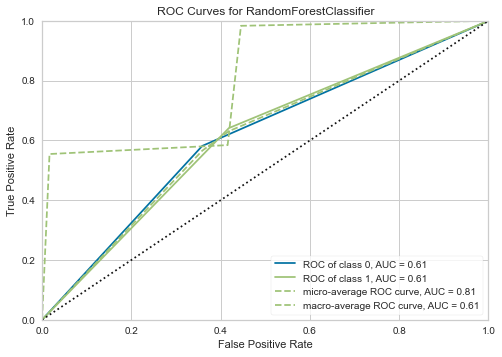

In [50]:
plot_model(tuned_model1)

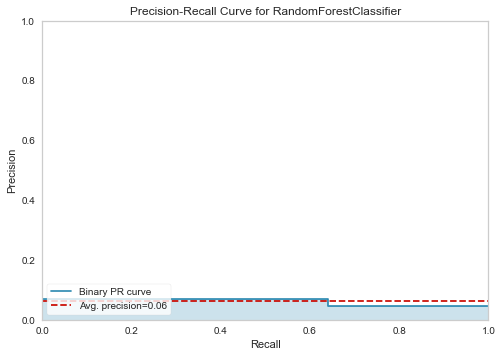

In [51]:
plot_model(tuned_model1,'pr')

In [46]:
plot_model(_model1,'parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


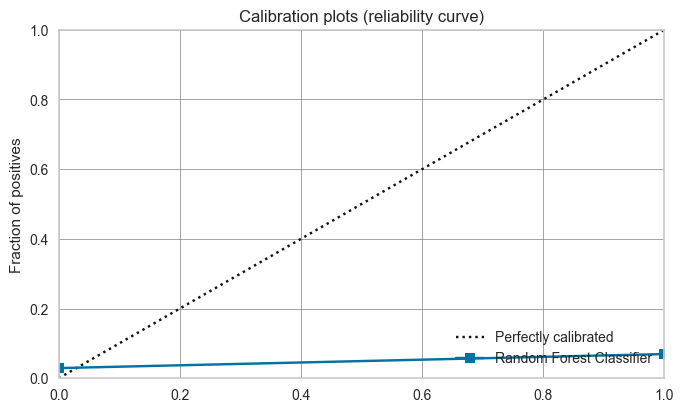

In [53]:
plot_model(tuned_model1,'calibration')

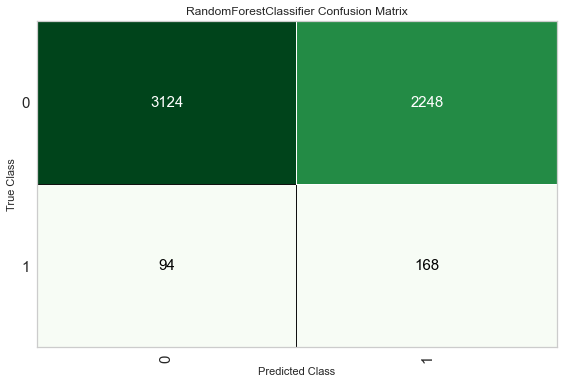

In [55]:
plot_model(_model1,'confusion_matrix')

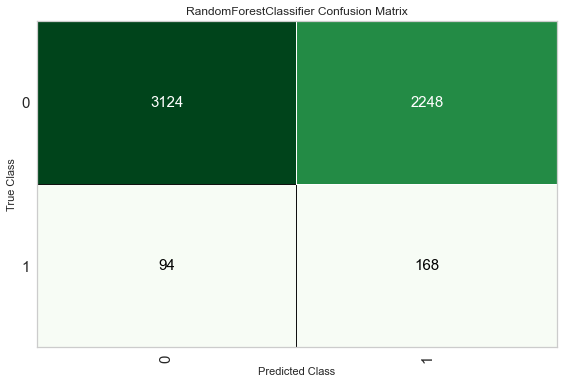

In [49]:
plot_model(tuned_model1,'confusion_matrix')

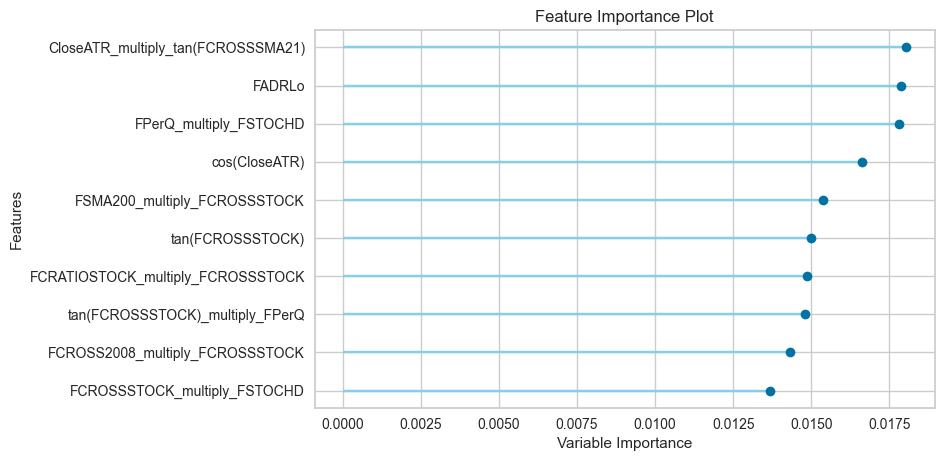

In [58]:
plot_model(_model1,'feature')

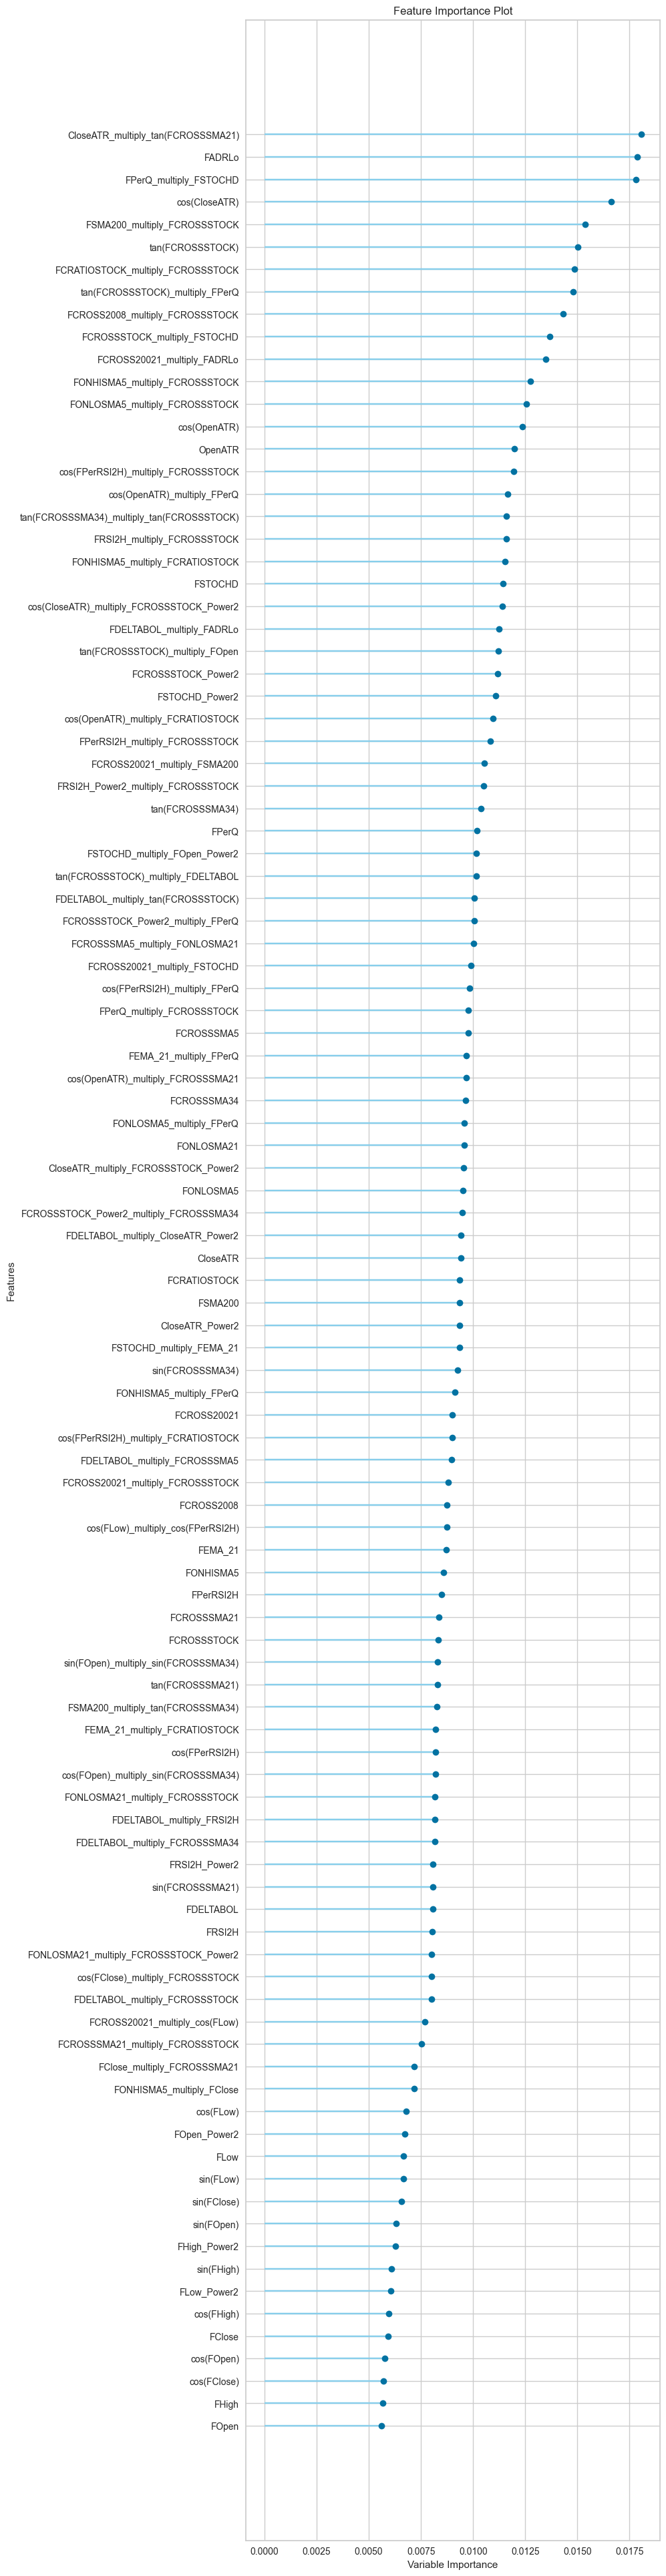

In [60]:
plot_model(_model1,'feature_all')

In [28]:
%%time
data_oos = predict_model(tuned_model1, data_oos)

CPU times: user 33.1 s, sys: 14.9 s, total: 48 s
Wall time: 34.7 s


In [ ]:
data_oos.Label.describe()

In [33]:
%%time
df_oos = database[(database.index >= _stop)&(database.index <= _last)]
df_oos['Valid'] = data_oos['Label']


df_oos['Signal'] = np.where((df_oos.Signal==1)&(df_oos.Valid==1),1,np.where((df_oos.Signal==-1)&(df_oos.Valid==1),-1,0))


##### On backtest selon le ticker selectionné sur la période déterminée

print(x)
_year_bottom = _stop
_year_top = _last

#_target = 0.002
#_sl = 0.001
#_nb_bougie_exit = 5555555

print()
print(col.Fore.GREEN,'###############################################################################################')
print(' ########################################### OOS AFTER AI ######################################')
print(' ###############################################################################################',col.Style.RESET_ALL)

##### Backtest Over Night
_trigger_rsi = 1
_trigger_invers = 1
_bt_report = 3
FINAL_TRACKER = bt(df_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_bt_report=_bt_report,_trigger_rsi=_trigger_rsi)

print(col.Fore.CYAN+'\n\nTRAITEMENT STATISTIQUE DES DONNEES\n',col.Style.RESET_ALL)
candle_feedback = joblib.load('BT/'+_ticker+'_candle_feedback_ai.dag')
candle_feedback = timerange1D(candle_feedback)
stats = candle_feedback.drop(['Symbol','Size','Date'],axis=1).calc_stats()
stats[_ticker].display()
print(col.Fore.CYAN+'\n\nMONTHLY RETURN FOR '+x+'\n',col.Style.RESET_ALL)
stats[_ticker].display_monthly_returns()
_trigger_rsi = 1
_trigger_invers = 0
_bt_report = 0


EUR/USD

 ###############################################################################################
 ########################################### OOS AFTER AI ######################################
 ############################################################################################### 


_________________________________________________

__________________________________
     ___ Period 1 : =>  m5  ___
     ___ Period 2 : =>  H1  ___
__________________________________
Ca$h Ini : 200000
Date début: 2017-12-31
Date fin : 2021-04-29
Etat verbose : 0
Nombre Bougies Exit : 5555555555
Target : 0.004
Stop Loss : 0.001
Trigger Reengage : 0
Trigger Target : 1
Trigger Inverse : 1
Trigger StopLoss : 1
Trigger RSI : 1
Exposure : 2
_bt_report :  3
Verbose :  0
Trigger Spread : 0.025
Save :  0

_________________________________________________


Début des opérations horodatée à 2021-05-04 16:08:07.082498

 _trigger_rsi : 1 


Chargement de la nouvelle base


 Le rate du ticker EUR/USD